In [86]:
%matplotlib inline
import pandas as pd
import pylab
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sci
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

import random
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.spatial.distance as ssd
from sklearn.ensemble import RandomForestClassifier
import sklearn
import gatspy
from gatspy import datasets, periodic
import statistics
from tsfresh import extract_features

ImportError: No module named 'tsfresh'

In [31]:


def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 1, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 1, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss



In [30]:
obs = pd.read_csv('C:/Users/Max/Downloads/data/training_set.csv')
meta = pd.read_csv('C:/Users/Max/Downloads/data/training_set_metadata_true.csv')

#total=obs.merge(meta,on='object_id')

In [4]:
def timeplot(id,num):
    
    for i in range(num):
        df=total[total['target']==id]
        sample=int(df.object_id.sample(n=1))
        df2=df[df['object_id']==sample]
        sns.lmplot(data=df2,x='mjd',y='flux',fit_reg=False,hue='passband')
        

In [59]:
    
df2=obs[['flux','passband','object_id']]
df3=pd.pivot_table(df2, index='object_id', columns=['passband'], aggfunc=max)
df3.columns = df3.columns.droplevel(0)
df3.columns = [str(col) + '_band_Max' for col in df3.columns]

df4=pd.pivot_table(df2, index='object_id', columns=['passband'], aggfunc=min)
df4.columns = df4.columns.droplevel(0)
df4.columns = [str(col) + '_band_Min' for col in df4.columns]

df5=pd.pivot_table(df2, index='object_id', columns=['passband'], aggfunc=np.median)
df5.columns = df5.columns.droplevel(0)
df5.columns = [str(col) + '_band_Median' for col in df5.columns]

df6=pd.pivot_table(df2, index='object_id', columns=['passband'], aggfunc=lambda x: sum(i>max(x)/3 for i in x))
df6.columns = df6.columns.droplevel(0)
df6.columns = [str(col) + '_band_High_Count' for col in df6.columns]

df7=pd.pivot_table(df2, index='object_id', columns=['passband'], aggfunc=lambda x: sum(i<min(x)/3 for i in x))
df7.columns = df7.columns.droplevel(0)
df7.columns = [str(col) + '_band_Low_Count' for col in df7.columns]

output=pd.concat([df3,df4,df5,df6,df7],axis=1)

    

In [66]:
output['object_id']=output.index

In [68]:
final=output.merge(meta,on='object_id')
final.head(5)

,0_band_Max,1_band_Max,2_band_Max,3_band_Max,4_band_Max,5_band_Max,0_band_Min,1_band_Min,2_band_Min,3_band_Min,...,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,period_passband_5,period_acc_passband_5,period,period_acc
0,125.182808,660.626343,611.984558,445.737061,381.953735,378.188141,-116.913223,-1100.440063,-681.858887,-530.644592,...,0.0000,0.0000,0.0000,NaN,0.017,92,0.929168,0.431992,0.481014,0.514880
1,14.509829,9.129021,10.529041,11.330316,9.827934,14.770886,-14.735178,-11.715749,-10.067919,-12.394593,...,1.8181,1.6267,0.2552,45.4063,0.007,88,0.998077,0.462318,0.996581,0.805843
2,5.942166,5.693109,20.994711,33.572102,41.159981,47.310059,-3.459960,-3.393080,-2.848838,-5.435799,...,0.2320,0.2262,0.0157,40.2561,0.021,42,0.999509,0.547195,0.999527,0.277414
3,18.014029,192.244293,220.795212,203.250702,183.633118,141.513290,-3.874349,-3.618410,-2.159753,-4.944036,...,0.3037,0.2813,1.1523,40.7951,0.007,90,0.998695,0.556385,0.998653,0.231534
4,5.330927,37.170177,106.671692,139.818405,143.600189,109.157585,-6.804703,-2.622109,-2.084535,-2.800270,...,0.1934,0.2415,0.0176,40.4166,0.024,90,0.994871,0.409594,0.999517,0.331534


C:\Users\Max\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


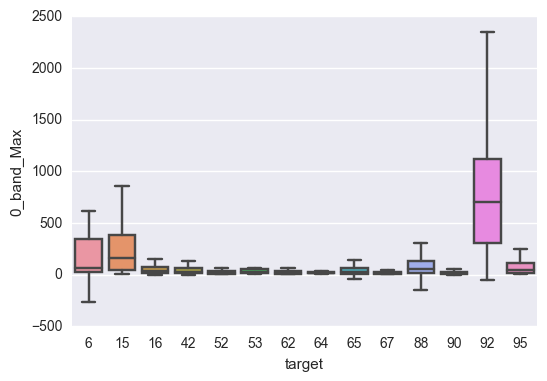

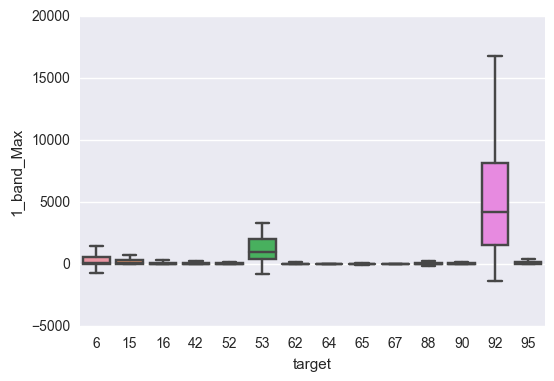

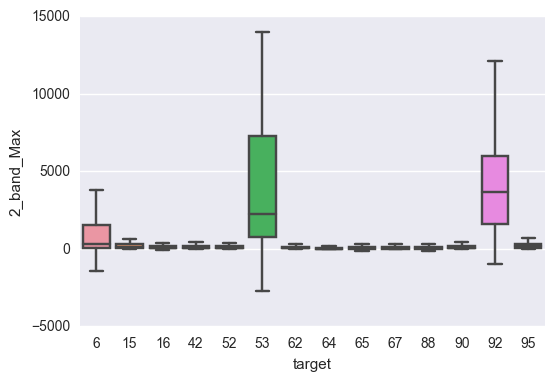

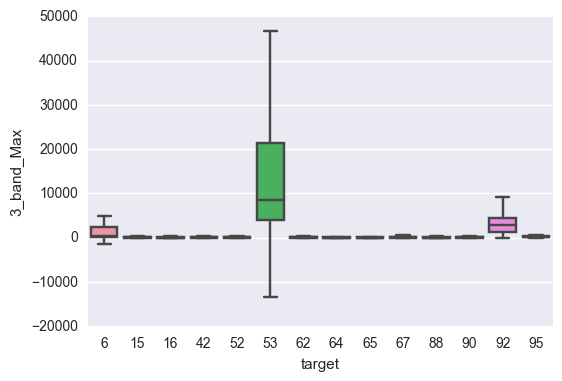

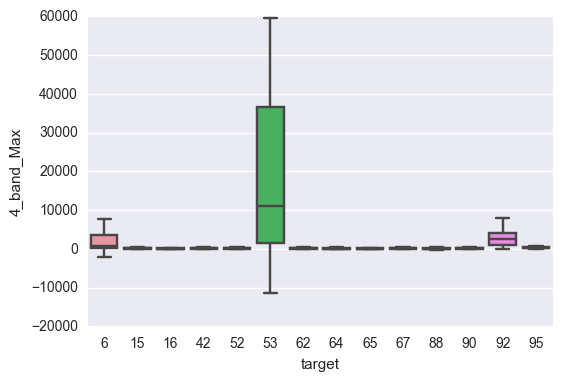

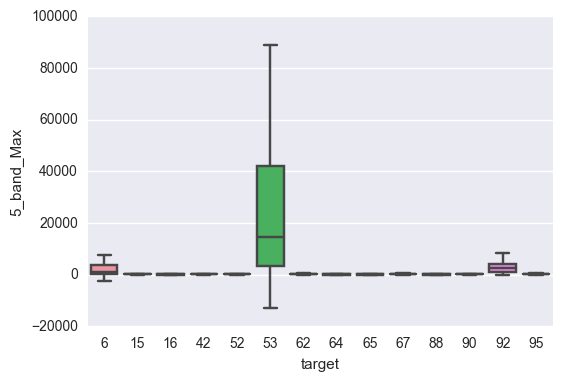

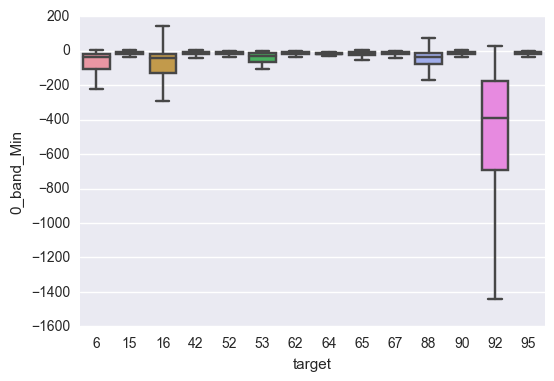

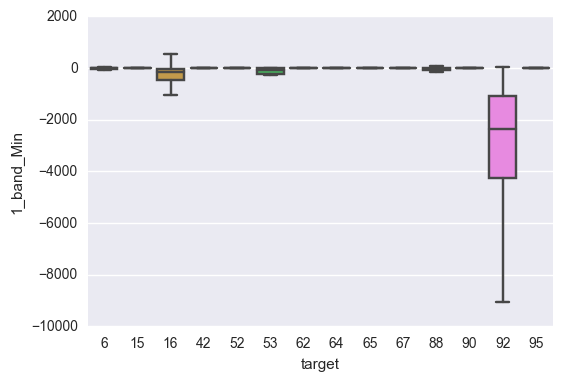

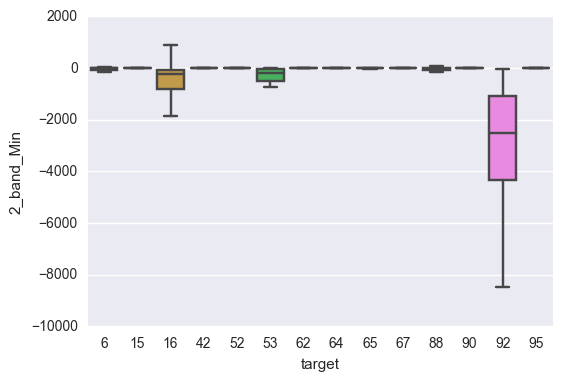

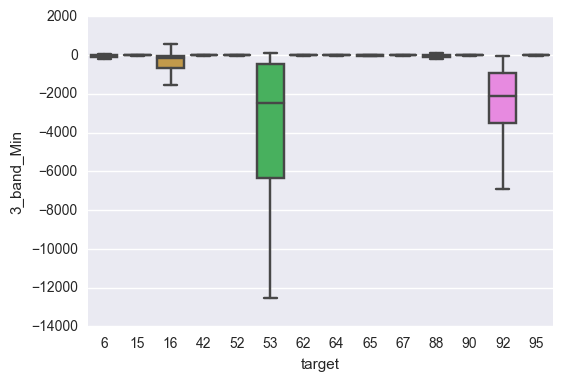

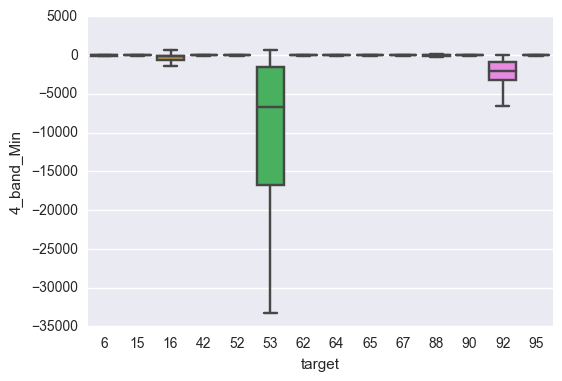

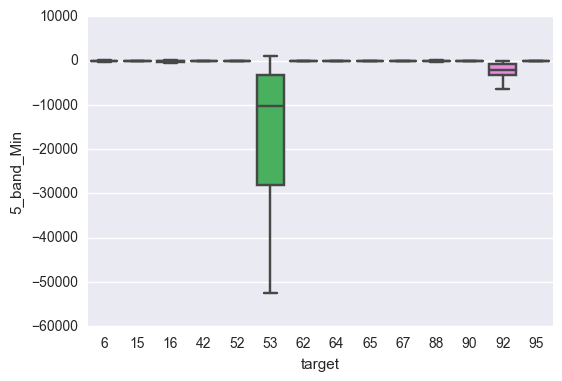

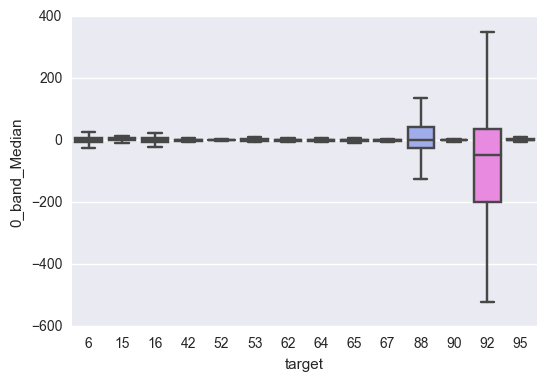

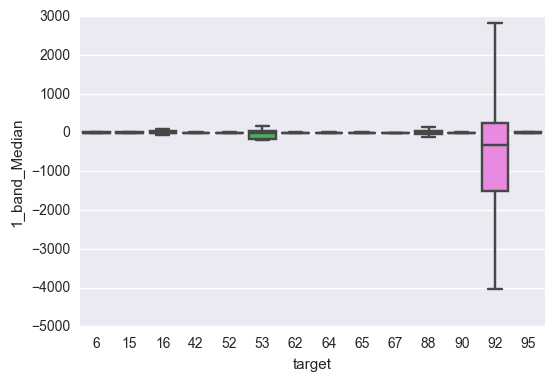

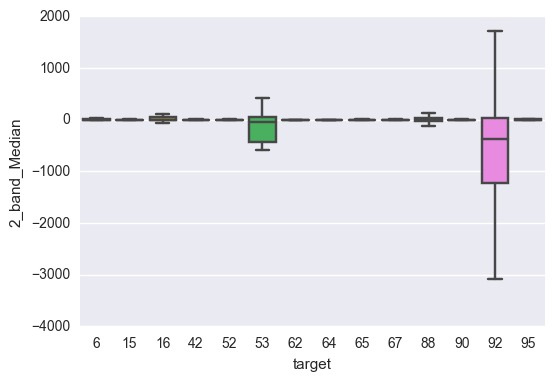

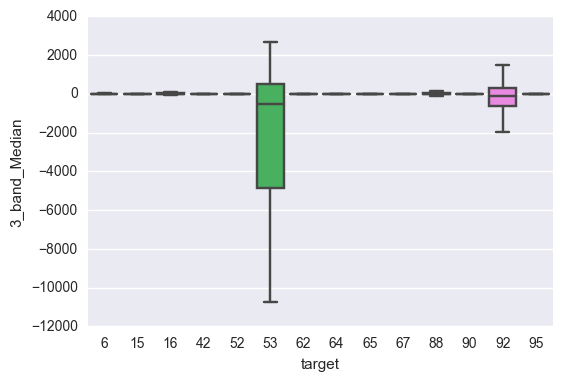

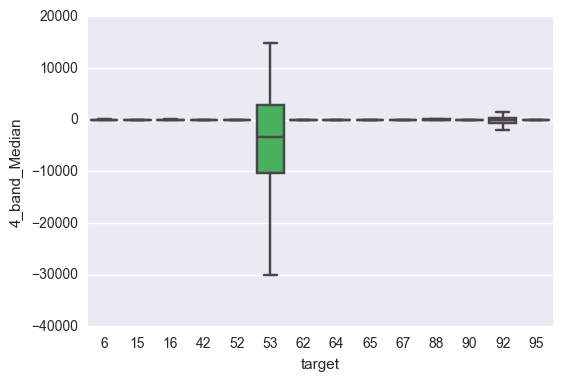

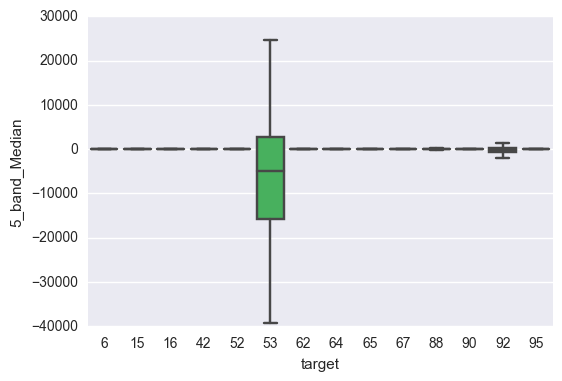

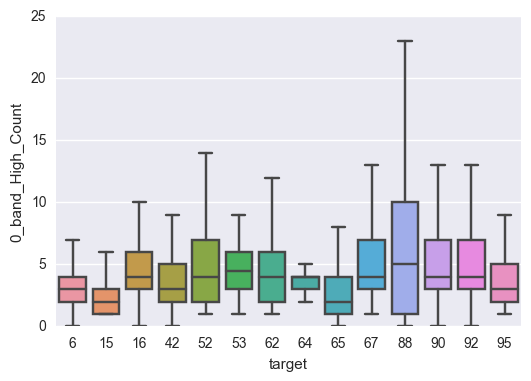

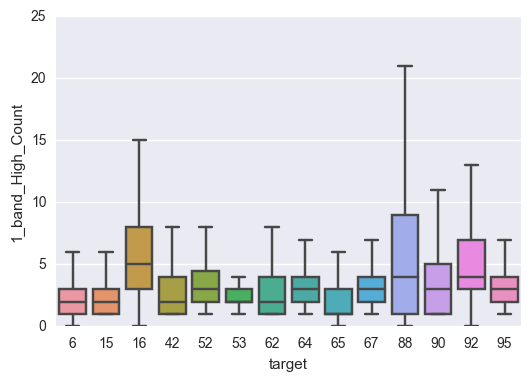

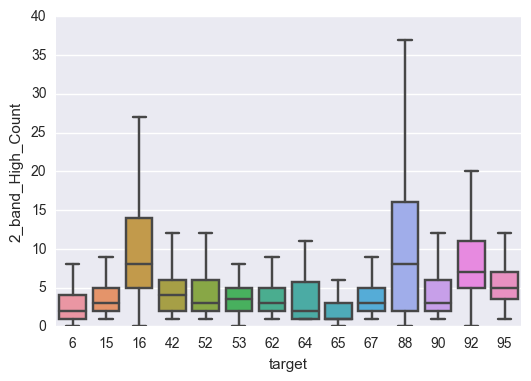

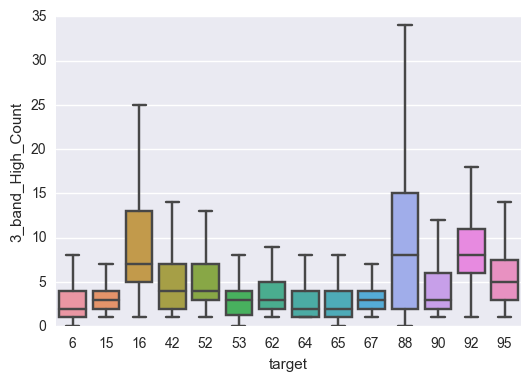

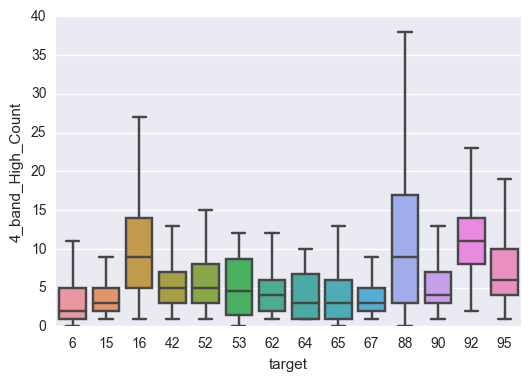

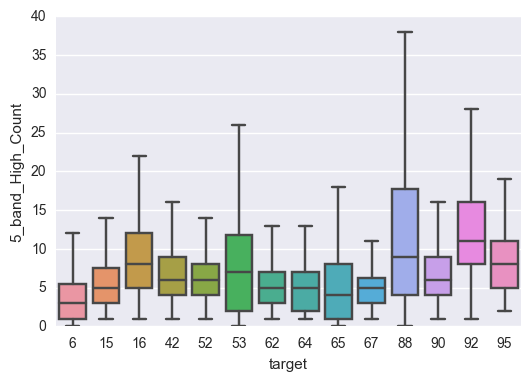

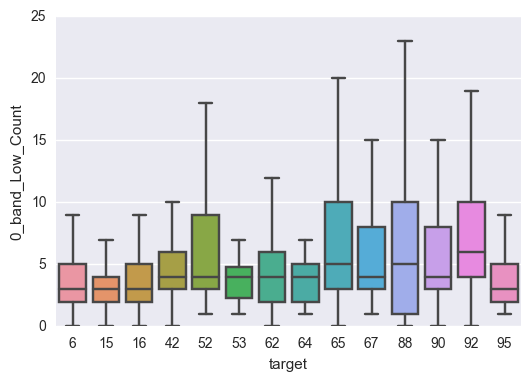

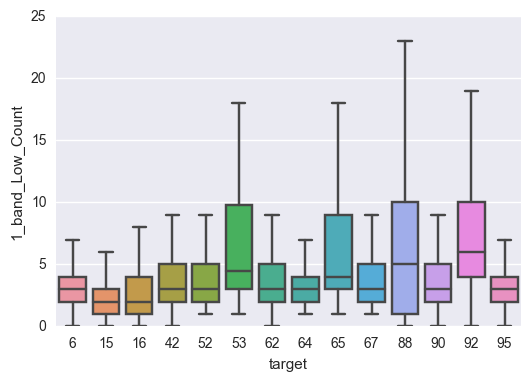

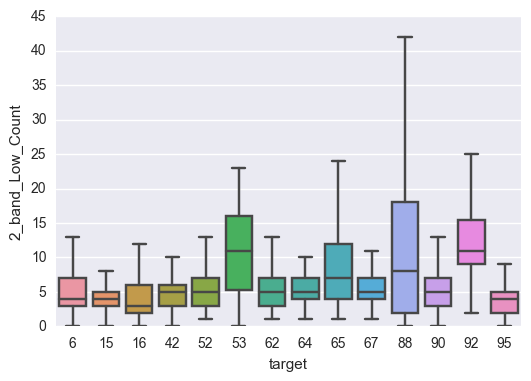

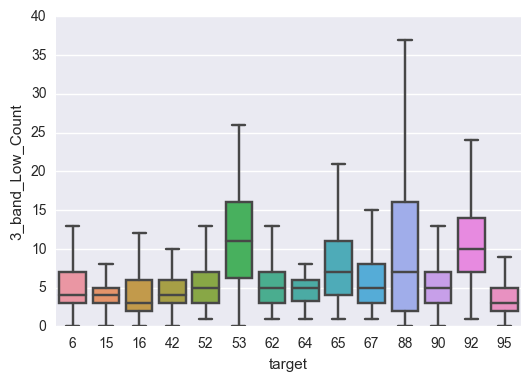

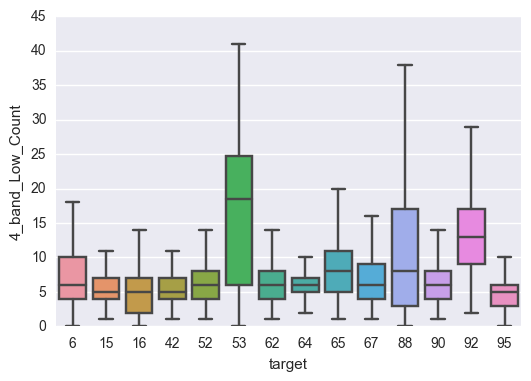

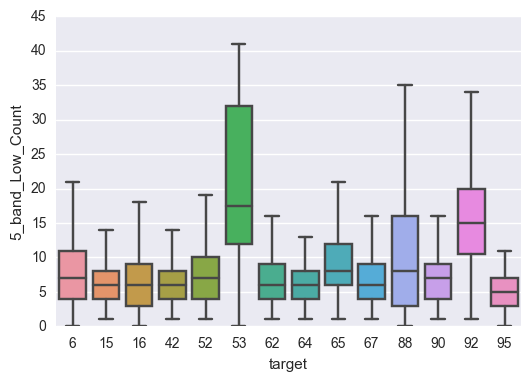

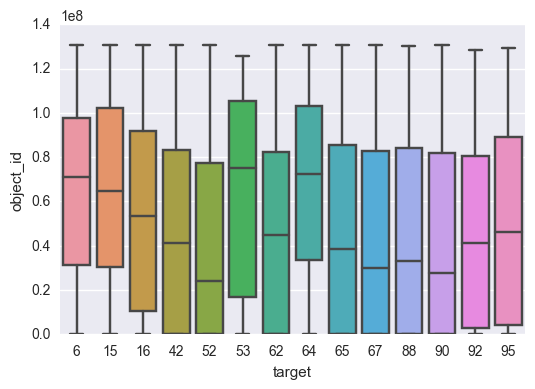

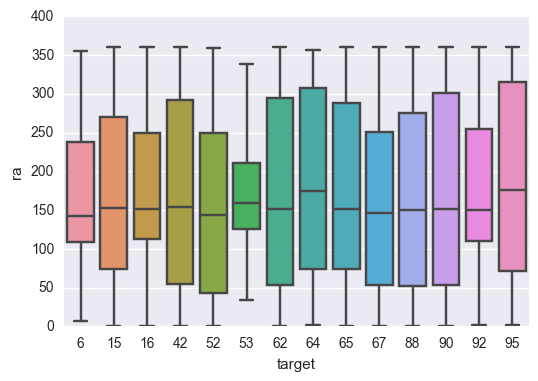

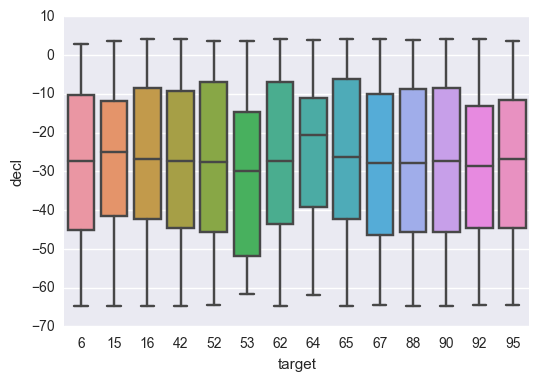

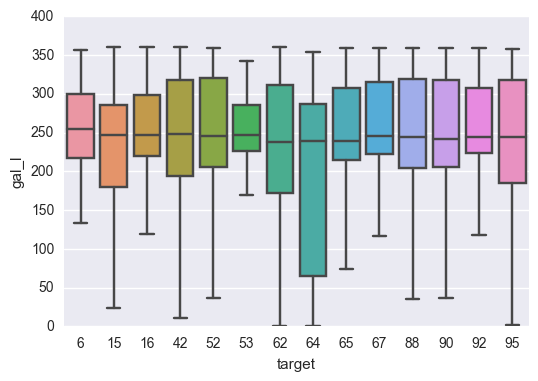

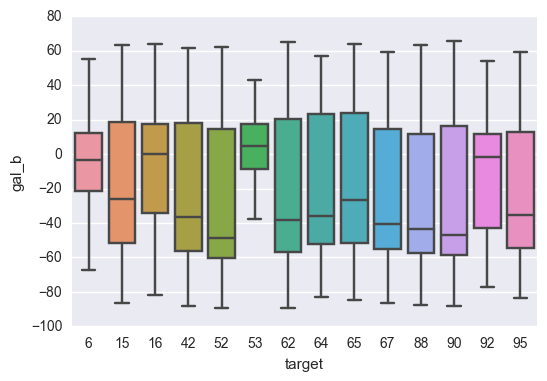

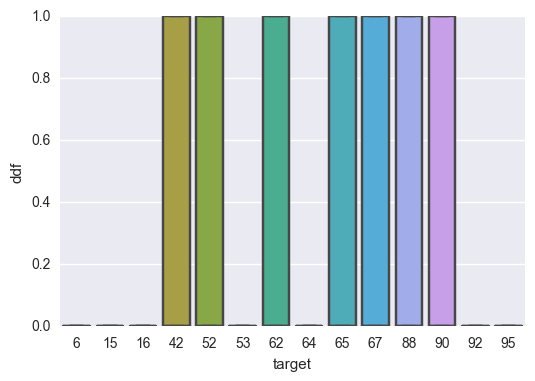

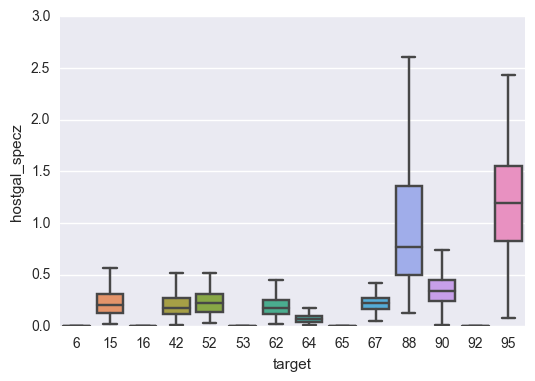

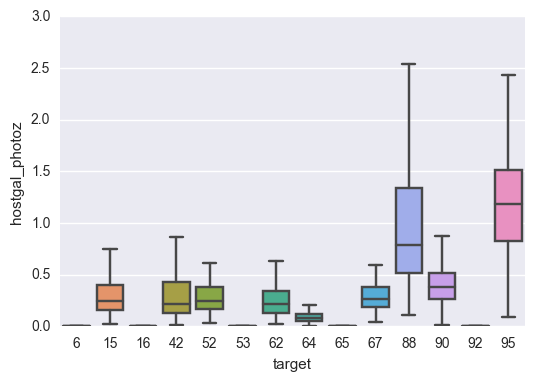

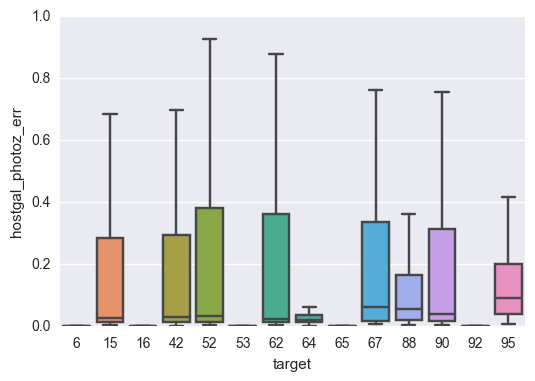

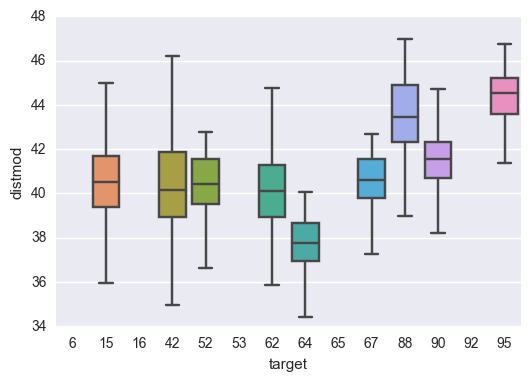

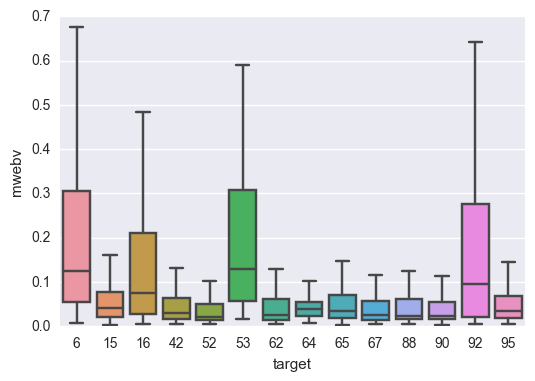

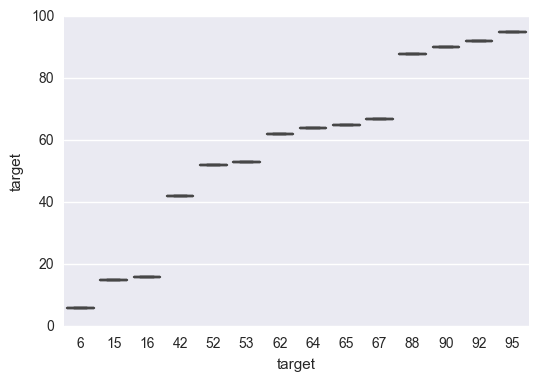

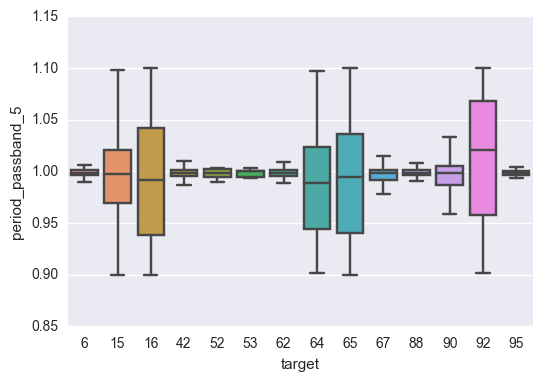

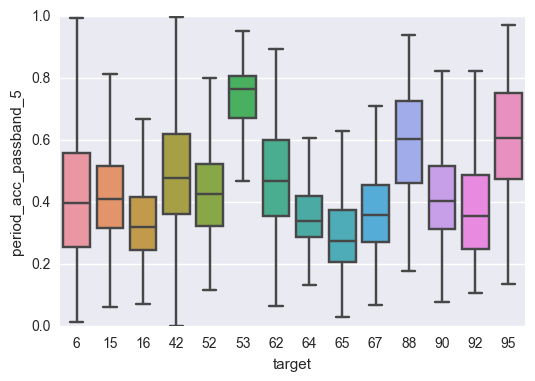

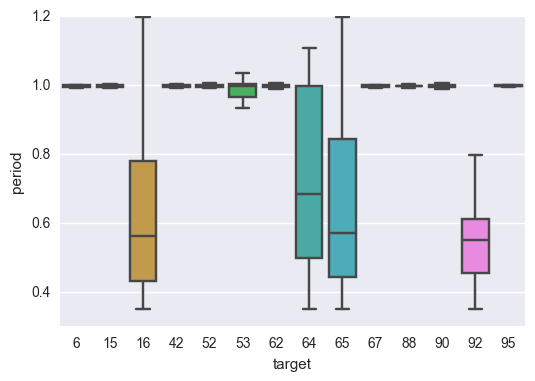

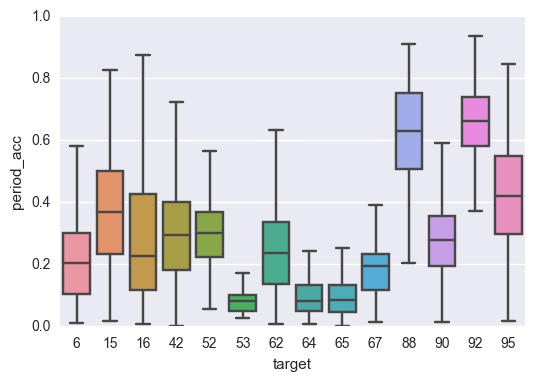

In [87]:
final2=final[(final.target!=53)&(final.target!=92)&(final.target!=6)&(final.target!=16)&(final.target!=88)]
for i, col in enumerate(final.columns):
    plt.figure(i)
    sns.boxplot(data=final,x='target',y=col,showfliers=False)